In [1]:
import numpy as np
from nilearn.signal import clean
import glob

In [2]:
DATASET_DIR = "../dataset/AOMIC"
TS_DIR = f"{DATASET_DIR}/TS"
NOISE_DIR = f"{DATASET_DIR}/Noise"
DATASET_FILE_SUFFIX = "_acq-seq_desc-confounds_regressors_6_motion_and_derivs.txt"
LABELS_DICT = {
    "task-restingstate": 0,
    "task-stopsignal": 1,
    "task-workingmemory": 2,
    "task-emomatching": 3,
}

In [3]:
def create_dataset():
    dataset = []
    labels = []

    data_files_paths = [i for i in glob.glob(f"{TS_DIR}/sub-*.txt")]
    data_files_paths.sort()
    data_files_names = [i.split("/")[-1] for i in data_files_paths]

    for data_file_path, data_file_name in zip(data_files_paths, data_files_names):
        # load dataset element
        data = np.loadtxt(data_file_path)

        file_name_parts = data_file_name.split("_")
        data_id = "_".join(file_name_parts[:2])

        # clean the element (denoise, detrend, standardize)
        noise = np.loadtxt(f"{NOISE_DIR}/{data_id}{DATASET_FILE_SUFFIX}")
        cleaned_data = clean(data, confounds=noise, standardize=True, detrend=True)
        dataset.append(cleaned_data)

        # get label
        label_key = file_name_parts[1]
        labels.append(LABELS_DICT[label_key])

    # make all elements of the dataset the same length (some time series are longer than others)
    shortest_data_len = min([len(item) for item in dataset])
    dataset = [item[:shortest_data_len] for item in dataset]

    return np.array(dataset), np.array(labels)

In [4]:
dataset, labels = create_dataset()

/var/folders/t_/mdbhrqg533x2vn19qt663qb40000gn/T/ipykernel_8716/873979475.py:18: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  cleaned_data = clean(data, confounds=noise, standardize=True, detrend=True)


In [5]:
# element x time x features
dataset.shape

(896, 135, 200)

In [6]:
ids = np.array([[id_value] * dataset.shape[1] for id_value in range(dataset.shape[0])])
ids = ids.reshape(-1)

ids.shape

(120960,)

In [7]:
# make dataset have 2 dimensions, with first dimension equal to ids length
values = dataset.reshape(-1, dataset.shape[2])
values.shape

# create pandas dataframe which will contains ids in one column and each value in a separate column
import pandas as pd

df = pd.DataFrame(values, columns=[f"brain_region_{i}" for i in range(values.shape[1])])
df["ids"] = ids
# make ids column the first column
df = df[["ids"] + [c for c in df if c not in ["ids"]]]
df.head(136)

,ids,brain_region_0,brain_region_1,brain_region_2,brain_region_3,brain_region_4,brain_region_5,brain_region_6,brain_region_7,brain_region_8,...,brain_region_190,brain_region_191,brain_region_192,brain_region_193,brain_region_194,brain_region_195,brain_region_196,brain_region_197,brain_region_198,brain_region_199
0,0,0.291041,1.359124,-0.272540,0.354970,-0.243757,-0.080673,0.240811,0.380591,2.772509,...,1.245135,1.634660,-0.305299,-1.334837,-0.000130,0.782817,0.782581,0.697078,0.040373,-0.695437
1,0,1.195915,2.472871,0.650180,1.322585,0.056440,0.271711,0.356396,1.218796,0.957343,...,1.793632,1.539774,1.209575,-1.174298,0.212753,1.246743,2.604119,2.571953,0.309654,0.450439
2,0,2.680325,2.651251,1.129318,1.933100,1.597842,1.815245,1.888429,1.155981,0.040805,...,0.911599,1.146434,1.350608,0.352084,1.007715,0.731714,1.499620,2.255785,2.453137,1.520261
3,0,0.363991,0.065520,-0.789160,-0.656149,0.714418,0.894148,0.565781,-0.471518,-0.180017,...,-0.230658,0.941324,0.922712,1.012025,0.943173,-0.298815,1.376881,0.802890,0.427442,0.778403
4,0,-0.022290,-0.160655,-0.411704,0.004884,1.325822,0.717133,0.570050,-0.711762,-0.536569,...,1.340307,1.183828,0.564890,2.291365,0.107274,0.404797,0.546145,0.945892,1.358619,-0.098629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0,0.282937,0.151616,0.962327,0.734961,0.602360,0.362651,0.827716,1.426143,1.233557,...,-0.101750,0.767341,-0.728032,-0.509141,0.088714,0.103818,0.652602,-0.030097,0.167992,1.847529
132,0,0.690774,1.086408,1.022373,0.769090,0.087152,-0.248720,-0.159010,0.458239,-0.087774,...,-0.126470,0.059405,1.055379,-0.669800,-0.009201,-0.254394,0.547182,1.131501,1.802907,1.177940
133,0,-0.541734,-0.291517,-0.552319,-1.079724,-0.932060,-1.396518,-1.303117,-0.466396,-0.703261,...,-0.415763,0.287828,0.568241,-0.665444,0.279544,-1.164606,1.125905,1.536681,1.302066,0.721102
134,0,-1.162012,-0.795092,-1.016122,-1.806747,-1.123370,-2.046695,-1.420470,-1.132268,-0.492121,...,-0.177021,-0.619622,0.332398,-1.024358,-2.454824,-1.325866,-1.024765,0.031310,-0.517997,-1.036272


In [8]:
# element x (id + brain regions count)
df.shape

(120960, 201)

In [9]:
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import EfficientFCParameters

In [10]:
features = extract_features(
    df[:],
    column_id="ids",
    default_fc_parameters=EfficientFCParameters(),
    column_value="brain_region_0",
)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.03it/s]


In [11]:
features.shape

(896, 777)

In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

In [14]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((716, 777), (180, 777), (716,), (180,))

In [15]:
x_train.columns = [f"region{i}" for i in range(x_train.shape[1])]
x_test.columns = [f"region{i}" for i in range(x_test.shape[1])]

In [16]:
classifier = lgb.LGBMClassifier()
classifier.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130774
[LightGBM] [Info] Number of data points in the train set: 716, number of used features: 592
[LightGBM] [Info] Start training from score -1.397530
[LightGBM] [Info] Start training from score -1.369673
[LightGBM] [Info] Start training from score -1.364194
[LightGBM] [Info] Start training from score -1.414625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

LGBMClassifier()

In [17]:
y_pred = classifier.predict(x_test)

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [19]:
accuracy = accuracy_score(y_test, y_pred, normalize=True)

In [20]:
print("LightGBM Model accuracy score: {0:0.4f}".format(accuracy))

LightGBM Model accuracy score: 0.8111


In [21]:
cm = confusion_matrix(y_test, y_pred).astype(np.float64)

for i in range(cm.shape[0]):
    cm[i, :] /= np.sum(cm[i, :])

cm_matrix = pd.DataFrame(data=cm)
label_names = [key.split("-")[1] for key in LABELS_DICT.keys()]
cm_matrix["types"] = np.array(label_names)

cm_matrix.set_index("types", inplace=True)
cm_matrix.columns = label_names

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns

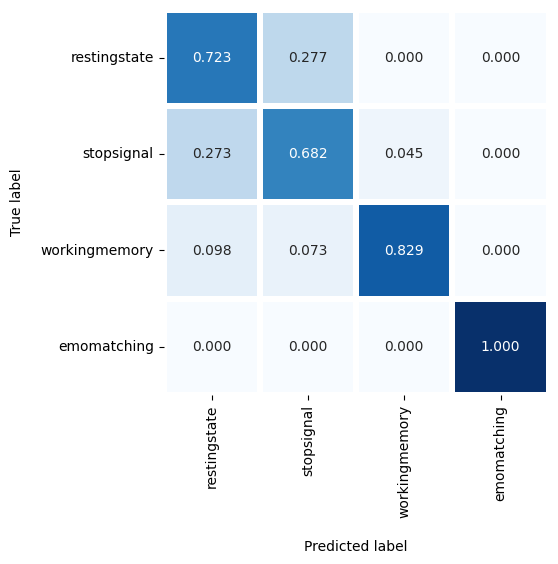

In [23]:
plt.figure(figsize=(7, 5))
sns.heatmap(
    cm_matrix,
    annot=True,
    fmt=".3f",
    square=True,
    cbar=False,
    cmap="Blues",
    linewidths=3,
    vmin=0,
    vmax=1,
)
plt.xlabel("Predicted label", labelpad=16)
plt.ylabel("True label", labelpad=12)
plt.tick_params(axis="y", rotation=0)
plt.show()